### Fetch the data

I' going to use the free API from [sunrisesunset.io](https://sunrisesunset.io/api/) to fetch the sunrise/sunset times for the current year. 

In [69]:
import requests as r

from dataclasses import dataclass
from datetime import datetime, date, timedelta

@dataclass 
class Location: 
    lat: float
    lon: float 

@dataclass
class DayDuration: 
    date: date
    duration: timedelta

    def as_hours(self):
        return self.duration.seconds / 60 / 60


Helsinki = Location(lat=60.192059, lon=24.945831)


In [70]:
input_date_format = '%Y-%m-%d'
input_time_format = '%H:%M:%S'

def parse_api_date_object(obj): 
    parsed_date = datetime.strptime(obj['date'], input_date_format).date()
    day_length = datetime.strptime(obj['day_length'], input_time_format).time()
    day_duration = datetime.combine(date.min, day_length) - datetime.min
    return DayDuration(parsed_date, day_duration)


In [71]:
def get_year_bounds(ref_date): 
    start_of_year = date(ref_date.year, 1, 1)
    end_of_year = date(ref_date.year, 12, 31)
    return start_of_year, end_of_year

def get_request_url(location, date_start, date_end): 
    return "https://api.sunrisesunset.io/json?lat={}&lng={}&date_start={}&date_end={}".format(location.lat, location.lon, date_start, date_end)

def request_day_length_data(location): 
    date_start, date_end = get_year_bounds(datetime.now())
    response = r.get(get_request_url(location, date_start, date_end))
    assert response.status_code == 200, "Error code: " + str(response.status_code)

    json = response.json()
    assert json['status'] == 'OK'
    return [parse_api_date_object(obj) for obj in json['results']] 


### Plotting the day length data 

Let's make a plot to show us how the day length gets longer or shorter during the year 

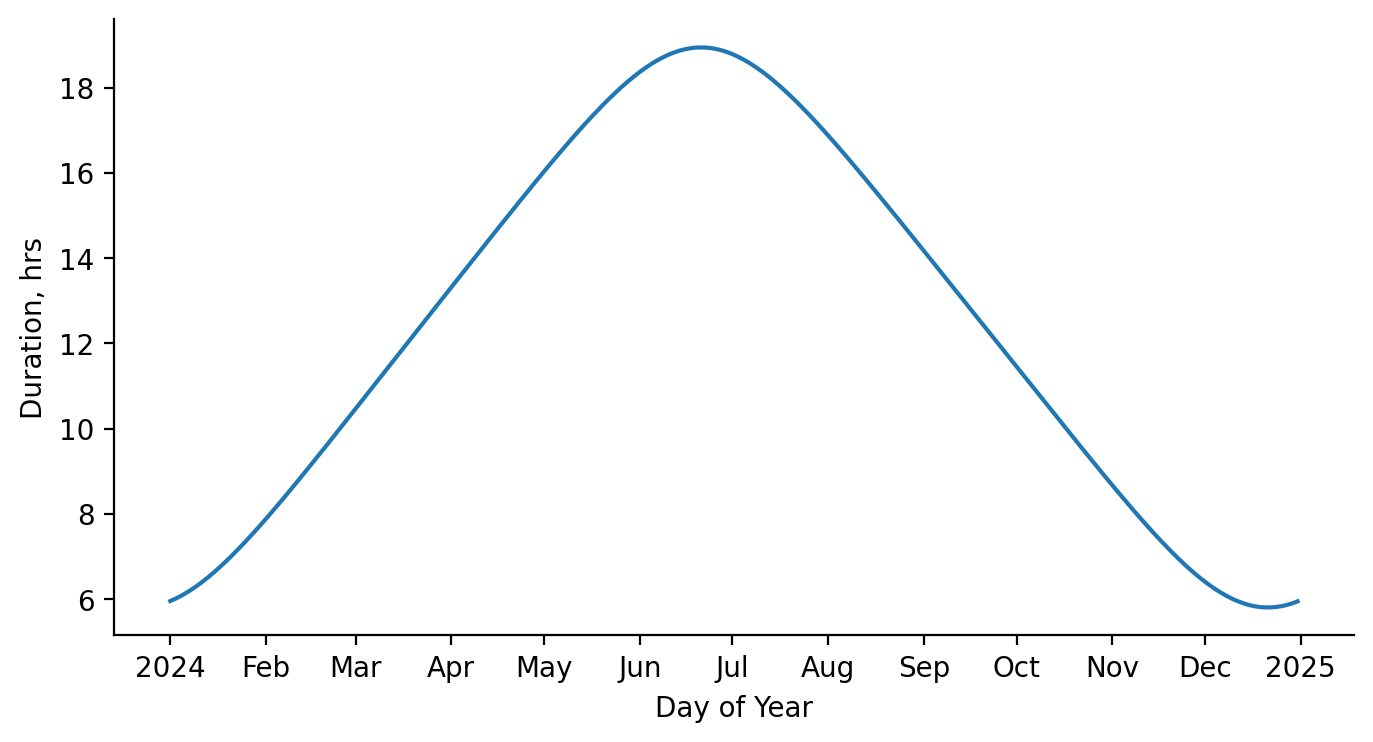

In [72]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

data = request_day_length_data(Helsinki)

xx = [d.date for d in data]
yy = [d.as_hours() for d in data]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(xx, yy)
ax.set_ylabel('Duration, hrs')
ax.set_xlabel('Day of Year')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

